# Machine Learning Internship Assignment

## Task two

This notebook demonstrates how an AI agent masters maze navigation through Q-Learning reinforcement learning. 

**Objectives:**
1. **Design the maze environment** and establish the action space available to the agent for movement.
2. **Develop core components** including **reward calculation, action selection strategy, Q-value updates, and agent training loop**.
3. **Execute agent training** using **Q-Learning** reinforcement learning algorithm.
4. **Build visualization** functions to display training progress and optimal path discovery.


The AI agent will use **epsilon-greedy exploration** to balance between exploiting learned knowledge and exploring new possibilities, gradually building a Q-table that maps state-action pairs to expected rewards for optimal maze traversal.

Import libraries

In [15]:
import numpy as np              # For numerical operations and array handling
import matplotlib.pyplot as plt # For visualization and plotting
import time                     # For adding delays in visualization
import random                   # For random number generation

There are 4 possible actions for the agent to move 

In [16]:
ACTIONS = [
    (-1,0), # Move Up
    (1,0), # Move Down
    (0,-1), # Move Left
    (0,1) # Move Right 
]

**Purpose**: Creates a 2D maze environment for pathfinding and navigation algorithms
- **Initialization**: Takes a maze layout (numpy array), start position, and goal position as input parameters
- **Maze Representation**: Uses binary values where 0 = walkable path and 1 = wall
- **Position Validation**: Checks if positions are within maze boundaries and not located on walls
- **Dimension Management**: Stores and provides access to maze height and width
- **Goal Detection**: Determines when an agent has successfully reached the target position

- **Visualization Features**:
    - Displays maze as grayscale image using matplotlib
    - Marks start position with red 'S'
    - Marks goal position with green 'G'
    - Shows agent path with blue dots 


- **Error Handling**: Validates start and goal positions, raising errors for invalid placements
Use Cases: Supports testing of pathfinding algorithms like A*, Dijkstra's, or reinforcement learning agents

In [17]:
class MazeEnvironment:          
    # This class represents the maze environment where the agent will navigate
    def __init__(self, maze_layout, start_pos, goal_pos):
        self.maze = maze_layout
        self.height = maze_layout.shape[0]    # Number of rows in maze
        self.width = maze_layout.shape[1]     # Number of columns in maze
        self.start_position = start_pos       # Starting position coordinates
        self.goal_position = goal_pos         # Goal position coordinates
        
    def _validate_positions(self):
        # Check if positions are within maze boundaries
        if not self._is_valid_position(self.start_position):
            raise ValueError("Start position is invalid or on a wall")
        if not self._is_valid_position(self.goal_position):
            raise ValueError("Goal position is invalid or on a wall")
    
    def _is_valid_position(self, position):        
        x, y = position
        # Check boundaries
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return False
        # Check if position is not a wall (0 = path, 1 = wall)
        if self.maze[y][x] == 1:
            return False
        return True
    
    def get_maze_dimensions(self):
        # Get the dimensions of the Maze
        return self.height, self.width
    
    def is_goal_reached(self, position):
        # Check if the agent has reached the goal
        return position == self.goal_position
    
    def display_maze(self, agent_path=None):        
        # Display the maze using matplotlib        
        # Create a new figure for the maze
        plt.figure(figsize=(8, 8))
        
        # Display maze as grayscale image (0=black/path, 1=white/wall)
        plt.imshow(self.maze, cmap='gray', alpha=0.8)
        
        # Mark start position with red 'S'
        plt.text(self.start_position[0], self.start_position[1], 'S',
                 ha='center', va='center', color='red', fontsize=20, weight='bold')
        
        # Mark goal position with green 'G'
        plt.text(self.goal_position[0], self.goal_position[1], 'G',
                 ha='center', va='center', color='green', fontsize=20, weight='bold')
        
        # If agent path is provided, mark it with blue dots
        if agent_path:
            for position in agent_path:
                if position != self.start_position and position != self.goal_position:
                    plt.text(position[0], position[1], '•',
                             ha='center', va='center', color='blue', fontsize=15)
        
        # Remove axis ticks for cleaner appearance
        plt.xticks([])
        plt.yticks([])
        plt.title("Maze Environment", fontsize=16)
        plt.show()

This  implements a Q-Learning AI agent that learns to navigate mazes.

- **Learns through trial and error** - starts knowing nothing about the maze and gradually learns the best paths
- **Uses a Q-table** - stores the "value" of taking each action from every position
- **Balances exploration** vs exploitation - initially tries random moves to learn, then gradually uses its learned knowledge
- **Gets rewards/penalties** - positive for reaching the goal, negative for hitting walls or taking steps
- **Trains over many episodes** - runs through the maze hundreds/thousands of times to improve
- **Tests performance** - after training, shows how efficiently it can solve the maze

In [18]:
class QLearningAgent:
    
    #Q-Learning agent that learns to navigate through the maze
    def __init__(self, maze_env, learning_rate=0.1, discount_factor=0.9, 
                 exploration_start=1.0, exploration_end=0.01, max_episodes=1000):
        
        #Initialize the Q-Learning agent
        self.maze = maze_env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.max_episodes = max_episodes
        
        # Initialize Q-table with zeros
        # Dimensions: [height, width, number_of_actions]
        self.q_table = self._initialize_q_table()
        
        # Keep track of training statistics
        self.training_rewards = []
        self.training_steps = []
    
    def _initialize_q_table(self):
        height, width = self.maze.get_maze_dimensions()
        return np.zeros((height, width, len(ACTIONS)))
    
    def _calculate_exploration_rate(self, current_episode):
       
        #Calculate exploration rate that decreases over time
        
        # Exponential decay of exploration rate
        decay_rate = (self.exploration_end / self.exploration_start) ** (current_episode / self.max_episodes)
        return self.exploration_start * decay_rate
    
    def choose_action(self, state, current_episode):
        
        #Choose an action using epsilon-greedy strategy
        
        exploration_rate = self._calculate_exploration_rate(current_episode)
        
        # Epsilon-greedy action selection
        if random.random() < exploration_rate:
            # Explore: choose random action
            return random.randint(0, 3)
        else:
            # Exploit: choose best action based on Q-table
            y, x = state[1], state[0]  # Convert (x,y) to (y,x) for array indexing
            return np.argmax(self.q_table[y, x, :])

    def update_q_value(self, current_state, action, next_state, reward):
        
        #Update Q-value using Q-learning formula

        # Convert positions to array indices
        curr_y, curr_x = current_state[1], current_state[0]
        next_y, next_x = next_state[1], next_state[0]
        
        # Get current Q-value
        current_q = self.q_table[curr_y, curr_x, action]
        
        # Find maximum Q-value for next state
        max_next_q = np.max(self.q_table[next_y, next_x, :])
        
        # Q-learning update formula
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        
        # Update Q-table
        self.q_table[curr_y, curr_x, action] = new_q

    def get_next_state(self, current_state, action):
        
        #Calculate next state based on current state and action
        
        dx, dy = ACTIONS[action]
        next_x = current_state[0] + dx
        next_y = current_state[1] + dy
        return (next_x, next_y)
    
    def train_agent(self, num_episodes=1000):
        
        #Train the agent using Q-learning algorithm
        print(f"Starting training for {num_episodes} episodes...")
        
        for episode in range(num_episodes):
            # Run one episode and get results
            total_reward, steps_taken, _ = self._run_episode(episode, training=True)
            
            # Store training statistics
            self.training_rewards.append(total_reward)
            self.training_steps.append(steps_taken)
            
            # Print progress every 100 episodes
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.training_rewards[-100:])
                avg_steps = np.mean(self.training_steps[-100:])
                print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, Avg Steps = {avg_steps:.2f}")
        
        print("Training completed!")
        self._plot_training_progress()

    def _run_episode(self, episode_num, training=True):
        
        #Run a single episode (either training or testing)
        
        current_state = self.maze.start_position
        total_reward = 0
        steps_taken = 0
        path = [current_state]
        max_steps = 1000  # Prevent infinite loops
        
        while steps_taken < max_steps:
            # Choose action
            if training:
                action = self.choose_action(current_state, episode_num)
            else:
                # For testing, always choose best action (no exploration)
                y, x = current_state[1], current_state[0]
                action = np.argmax(self.q_table[y, x, :])
            
            # Get next state
            next_state = self.get_next_state(current_state, action)
            
            # Calculate reward
            reward = self._calculate_reward(current_state, next_state)
            
            # Update total reward and step count
            total_reward += reward
            steps_taken += 1
            
            # Update Q-table if training
            if training:
                valid_next_state = next_state if self.maze._is_valid_position(next_state) else current_state
                self.update_q_value(current_state, action, valid_next_state, reward)
            # Check if goal is reached
            if self.maze._is_valid_position(next_state) and self.maze.is_goal_reached(next_state):
                current_state = next_state
                path.append(current_state)
                break
            
            # Update current state and path
            if self.maze._is_valid_position(next_state):
                current_state = next_state
                path.append(current_state)
        
        return total_reward, steps_taken, path
    
    def _calculate_reward(self, current_state, next_state):
        
        #Calculate reward for moving from current_state to next_state
      
        # Define reward values
        GOAL_REWARD = 100      # Reward for reaching goal
        WALL_PENALTY = -10     # Penalty for hitting wall
        STEP_PENALTY = -1      # Small penalty for each step
        
        # Check if next state is valid
        if not self.maze._is_valid_position(next_state):
            return WALL_PENALTY
        
        # Check if goal is reached
        if self.maze.is_goal_reached(next_state):
            return GOAL_REWARD
        
        # Regular step penalty
        return STEP_PENALTY
    
    def test_agent(self, num_tests=1, show_path=True):
        
        #Test the trained agent
        
        print(f"Testing agent for {num_tests} runs...")
        
        total_steps = 0
        total_rewards = 0
        
        for test in range(num_tests):
            reward, steps, path = self._run_episode(0, training=False)
            total_steps += steps
            total_rewards += reward
            
            print(f"Test {test + 1}: Steps = {steps}, Reward = {reward}")
            
            if show_path and test == 0:  # Show path for first test only
                print("Agent's path:")
                for i, pos in enumerate(path):
                    print(f"Step {i}: {pos}")
                
                # Display maze with agent's path
                self.maze.display_maze(agent_path=path)
        
        avg_steps = total_steps / num_tests
        avg_reward = total_rewards / num_tests
        
        print(f"Average Steps: {avg_steps:.2f}")
        print(f"Average Reward: {avg_reward:.2f}")
        
        return avg_steps, avg_reward
    
    def _plot_training_progress(self):
        #Plot training progress showing rewards and steps over episodes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot rewards
        ax1.plot(self.training_rewards)
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.set_title('Training Rewards Over Time')
        ax1.grid(True)
        
        # Plot steps
        ax2.plot(self.training_steps)
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Steps Taken')
        ax2.set_title('Training Steps Over Time')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

Creating a simple Maze

In [19]:
def create_sample_maze():
    
    # Create a simple 7x7 maze
    # 0 = path (black), 1 = wall (white)
    maze_layout = np.array([
        [0, 1, 0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0]
    ])
    return maze_layout

The Main function where calling all the functions mentioned in the class

In [20]:
def main():
    #Main function to run the maze solving program
    print("=== AI Maze Solver using Q-Learning ===\n")
    
    # Create maze environment
    maze_layout = create_sample_maze()
    start_position = (0, 0)  # Top-left corner
    goal_position = (3, 6)   # Bottom-right corner
    
    # Initialize maze environment
    maze_env = MazeEnvironment(maze_layout, start_position, goal_position)
    
    print("Initial Maze:")
    maze_env.display_maze()
    
    # Create and train agent
    agent = QLearningAgent(maze_env, learning_rate=0.1, discount_factor=0.9)
    
    # Test untrained agent
    print("\n--- Testing Untrained Agent ---")
    agent.test_agent(num_tests=3, show_path=False)
    
    # Train the agent
    print("\n--- Training Agent ---")
    agent.train_agent(num_episodes=500)
    
    # Test trained agent
    print("\n--- Testing Trained Agent ---")
    agent.test_agent(num_tests=5, show_path=True)


=== AI Maze Solver using Q-Learning ===

Initial Maze:


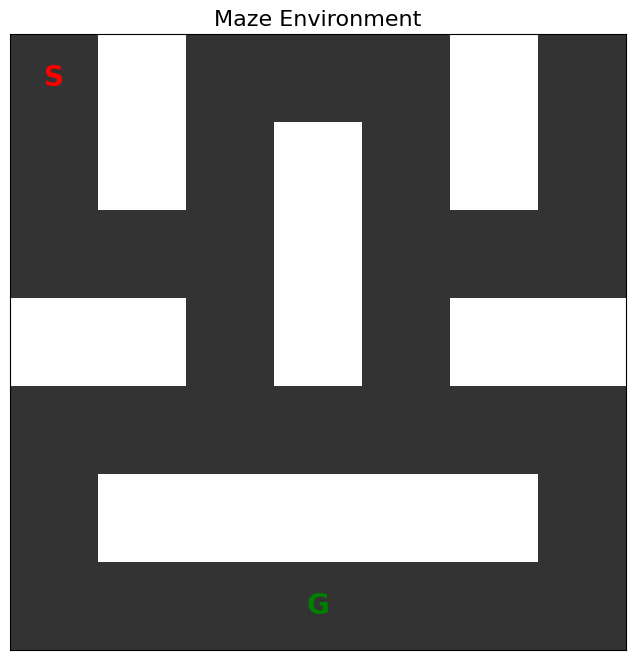


--- Testing Untrained Agent ---
Testing agent for 3 runs...
Test 1: Steps = 1000, Reward = -10000
Test 2: Steps = 1000, Reward = -10000
Test 3: Steps = 1000, Reward = -10000
Average Steps: 1000.00
Average Reward: -10000.00

--- Training Agent ---
Starting training for 500 episodes...
Episode 100: Avg Reward = -433.34, Avg Steps = 108.71
Episode 200: Avg Reward = 3.84, Avg Steps = 29.48
Episode 300: Avg Reward = 52.44, Avg Steps = 19.49
Episode 400: Avg Reward = 70.34, Avg Steps = 16.44
Episode 500: Avg Reward = 77.56, Avg Steps = 14.98
Training completed!


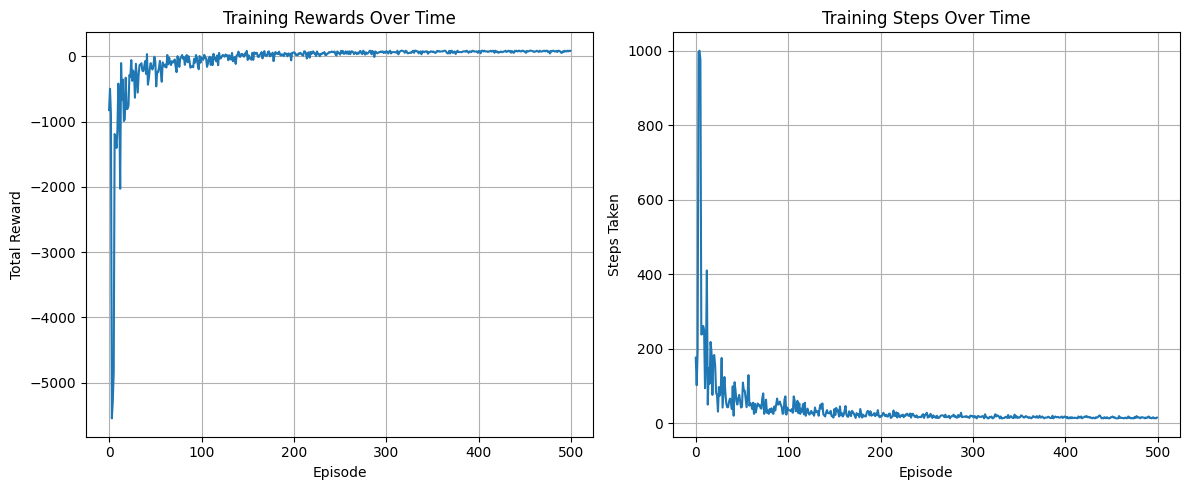


--- Testing Trained Agent ---
Testing agent for 5 runs...
Test 1: Steps = 13, Reward = 88
Agent's path:
Step 0: (0, 0)
Step 1: (0, 1)
Step 2: (0, 2)
Step 3: (1, 2)
Step 4: (2, 2)
Step 5: (2, 3)
Step 6: (2, 4)
Step 7: (1, 4)
Step 8: (0, 4)
Step 9: (0, 5)
Step 10: (0, 6)
Step 11: (1, 6)
Step 12: (2, 6)
Step 13: (3, 6)


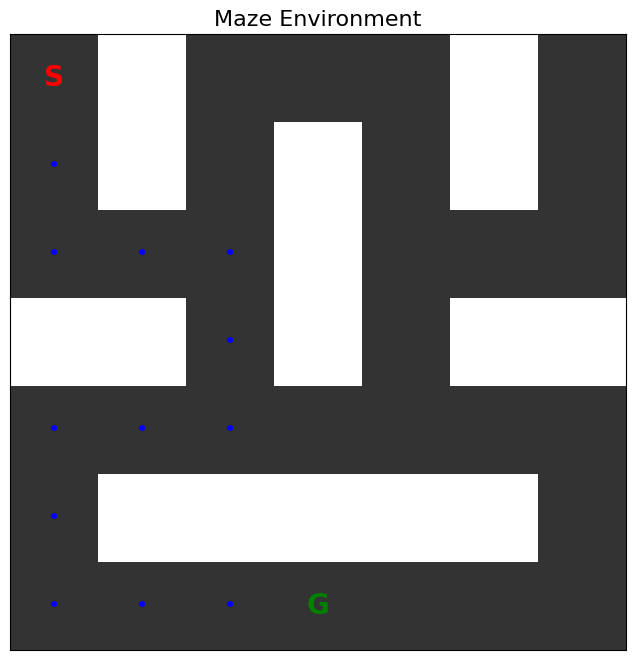

Test 2: Steps = 13, Reward = 88
Test 3: Steps = 13, Reward = 88
Test 4: Steps = 13, Reward = 88
Test 5: Steps = 13, Reward = 88
Average Steps: 13.00
Average Reward: 88.00


In [21]:
# Run the program
if __name__ == "__main__":
    main()